In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df_partitions = pd.read_csv("c3_muse_stress/metadata/partition.csv")
features_path = "c3_muse_stress/feature_segments"
labels_path = "c3_muse_stress/label_segments"

# Load a subject's data
def load_data(id):
    df_bpm = pd.read_csv(f'{features_path}/BPM/{id}.csv').drop(columns=['segment_id'])
    df_ecg = pd.read_csv(f'{features_path}/ECG/{id}.csv').drop(columns=['segment_id'])
    df_resp = pd.read_csv(f'{features_path}/resp/{id}.csv').drop(columns=['segment_id'])
    df_arousal = pd.read_csv(f'{labels_path}/arousal/{id}.csv').drop(columns=['segment_id'])
    df_valence = pd.read_csv(f'{labels_path}/valence/{id}.csv').drop(columns=['segment_id'])
    df_arousal.columns = ['timestamp', 'arousal']
    df_valence.columns = ['timestamp', 'valence']
    return df_bpm, df_ecg, df_resp, df_arousal, df_valence

def merge_dataframes(df_bpm, df_ecg, df_resp, df_arousal, df_valence):
    df = pd.merge_asof(df_bpm, df_ecg, on='timestamp')
    df = pd.merge_asof(df, df_resp, on='timestamp')
    df = pd.merge_asof(df, df_arousal, on='timestamp')
    df = pd.merge_asof(df, df_valence, on='timestamp')
    return df.dropna()

# Split data into train and devel
train_ids = df_partitions[df_partitions['Proposal'] == 'train']['Id']
devel_ids = df_partitions[df_partitions['Proposal'] == 'devel']['Id']

train_data = [merge_dataframes(*load_data(id)) for id in train_ids]
devel_data = [merge_dataframes(*load_data(id)) for id in devel_ids]

train_df = pd.concat(train_data)
devel_df = pd.concat(devel_data)

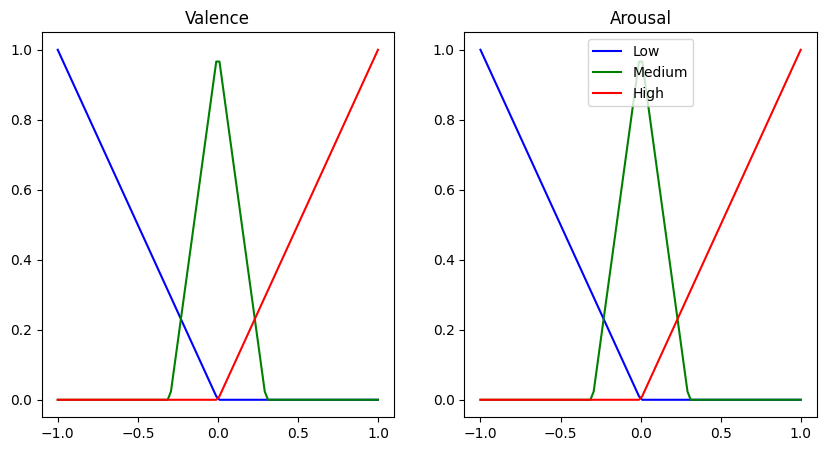

In [2]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt

valence = np.linspace(-1, 1, 100)
arousal = np.linspace(-1, 1, 100)

# Define fuzzy membership functions for valence
valence_negative = fuzz.trimf(valence, [-1, -1, 0])
valence_neutral = fuzz.trimf(valence, [-0.3, 0, 0.3])
valence_positive = fuzz.trimf(valence, [0, 1, 1])

# Define fuzzy membership functions for arousal
arousal_negative = fuzz.trimf(arousal, [-1, -1, 0])
arousal_neutral = fuzz.trimf(arousal, [-0.3, 0, 0.3])
arousal_positive = fuzz.trimf(arousal, [0, 1, 1])

# Visualize these universes and membership functions
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))

axs[0].plot(valence, valence_negative, 'b', linewidth=1.5, label='Negative')
axs[0].plot(valence, valence_neutral, 'g', linewidth=1.5, label='Neutral')
axs[0].plot(valence, valence_positive, 'r', linewidth=1.5, label='Positive')
axs[0].set_title('Valence')
axs[1].plot(arousal, arousal_negative, 'b', linewidth=1.5, label='Low')
axs[1].plot(arousal, arousal_neutral, 'g', linewidth=1.5, label='Medium')
axs[1].plot(arousal, arousal_positive, 'r', linewidth=1.5, label='High')
axs[1].set_title('Arousal')
axs[1].legend()

fig.set_size_inches(10, 5)
plt.show()

In [3]:
# Fuzzification
valence_low = fuzz.interp_membership(valence, valence_negative, train_df.valence)
valence_medium = fuzz.interp_membership(valence, valence_neutral, train_df.valence)
valence_high = fuzz.interp_membership(valence, valence_positive, train_df.valence)

arousal_low = fuzz.interp_membership(arousal, arousal_negative, train_df.arousal)
arousal_medium = fuzz.interp_membership(arousal, arousal_neutral, train_df.arousal)
arousal_high = fuzz.interp_membership(arousal, arousal_positive, train_df.arousal)

# Fuzzy rules
rule_elation = np.fmin(valence_high, arousal_high)
rule_happy = np.fmin(valence_high, arousal_medium)
rule_relaxed = np.fmin(valence_high, arousal_low)
rule_alert = np.fmin(valence_medium, arousal_high)
rule_neutral = np.fmin(valence_medium, arousal_medium)
rule_tired = np.fmin(valence_medium, arousal_low)
rule_fear = np.fmin(valence_low, arousal_high)
rule_stress = np.fmin(valence_low, arousal_medium)
rule_sad = np.fmin(valence_low, arousal_low)

# Rule set outputs
"""
The value received from this calculation will be in the interval [0,
1] and represent the degree of belonging of the current set of input
data to the specific emotion to which the rule corresponds.
Each rule will result in an output that is a set that is as follows. 

FR={a / elation, b / happy , c / relaxed, d / alert, e / neutral, f / tired, g / fear, h / stress, i / sad}

Where a, b, c, d, e, f, g, h, i are the values of the membership functions of the output variable emotion.
"""

f = np.zeros((train_df.shape[0], 9))

f[:, 0] = np.fmin(rule_elation, 1)
f[:, 1] = np.fmin(rule_happy, 1)
f[:, 2] = np.fmin(rule_relaxed, 1)
f[:, 3] = np.fmin(rule_alert, 1)
f[:, 4] = np.fmin(rule_neutral, 1)
f[:, 5] = np.fmin(rule_tired, 1)
f[:, 6] = np.fmin(rule_fear, 1)
f[:, 7] = np.fmin(rule_stress, 1)
f[:, 8] = np.fmin(rule_sad, 1)

# Defuzzification
emotion = np.argmax(f, axis=1)

In [4]:
train_df['label'] = emotion
train_df['label_txt'] = train_df['label'].map({0: 'elation', 1: 'happy', 2: 'relaxed', 3: 'alert', 4: 'neutral', 5: 'tired', 6: 'fear', 7: 'stress', 8: 'sad'})

In [5]:
import plotly.express as px

fig = px.scatter(train_df, x='valence', y='arousal', color='label_txt')
fig.update_layout(width=800, height=500)
fig.show()

In [7]:
# fuzzyfy devel
valence_low = fuzz.interp_membership(valence, valence_negative, devel_df.valence)
valence_medium = fuzz.interp_membership(valence, valence_neutral, devel_df.valence)
valence_high = fuzz.interp_membership(valence, valence_positive, devel_df.valence)

arousal_low = fuzz.interp_membership(arousal, arousal_negative, devel_df.arousal)
arousal_medium = fuzz.interp_membership(arousal, arousal_neutral, devel_df.arousal)
arousal_high = fuzz.interp_membership(arousal, arousal_positive, devel_df.arousal)

# Fuzzy rules
rule_elation = np.fmin(valence_high, arousal_high)
rule_happy = np.fmin(valence_high, arousal_medium)
rule_relaxed = np.fmin(valence_high, arousal_low)
rule_alert = np.fmin(valence_medium, arousal_high)
rule_neutral = np.fmin(valence_medium, arousal_medium)
rule_tired = np.fmin(valence_medium, arousal_low)
rule_fear = np.fmin(valence_low, arousal_high)
rule_stress = np.fmin(valence_low, arousal_medium)
rule_sad = np.fmin(valence_low, arousal_low)

# Rule set outputs
f = np.zeros((devel_df.shape[0], 9))

f[:, 0] = np.fmin(rule_elation, 1)
f[:, 1] = np.fmin(rule_happy, 1)
f[:, 2] = np.fmin(rule_relaxed, 1)
f[:, 3] = np.fmin(rule_alert, 1)
f[:, 4] = np.fmin(rule_neutral, 1)
f[:, 5] = np.fmin(rule_tired, 1)
f[:, 6] = np.fmin(rule_fear, 1)
f[:, 7] = np.fmin(rule_stress, 1)
f[:, 8] = np.fmin(rule_sad, 1)

# Defuzzification
emotion = np.argmax(f, axis=1)

devel_df['label'] = emotion
devel_df['label_txt'] = devel_df['label'].map({0: 'elation', 1: 'happy', 2: 'relaxed', 3: 'alert', 4: 'neutral', 5: 'tired', 6: 'fear', 7: 'stress', 8: 'sad'})


import plotly.express as px

fig = px.scatter(devel_df, x='valence', y='arousal', color='label_txt')
fig.update_layout(width=800, height=500)
fig.show()


In [8]:
# train classifier

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

X_train = train_df[['BPM', 'ECG', 'resp']]
y_train = train_df['label']

X_devel = devel_df[['BPM', 'ECG', 'resp']]
y_devel = devel_df['label']

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_devel = scaler.transform(X_devel)

In [9]:
# train neural network classifier
import torch
import torch.nn as nn
import torch.optim as optim

class EmotionClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(EmotionClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
input_size = 3
hidden_size = 100
num_classes = 9
learning_rate = 0.01
num_epochs = 100

model = EmotionClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.values, dtype=torch.long)

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

X_devel = torch.tensor(X_devel, dtype=torch.float32)
y_devel = torch.tensor(y_devel.values, dtype=torch.long)

model.eval()
with torch.no_grad():
    outputs = model(X_devel)
    _, predicted = torch.max(outputs, 1)
    print(f'Accuracy: {accuracy_score(y_devel, predicted)}')
    print(classification_report(y_devel, predicted))


Epoch [10/100], Loss: 1.8200100660324097
Epoch [20/100], Loss: 1.7601686716079712
Epoch [30/100], Loss: 1.7384272813796997
Epoch [40/100], Loss: 1.7268563508987427
Epoch [50/100], Loss: 1.7177386283874512
Epoch [60/100], Loss: 1.7098315954208374
Epoch [70/100], Loss: 1.7024719715118408
Epoch [80/100], Loss: 1.6957319974899292
Epoch [90/100], Loss: 1.6893798112869263
Epoch [100/100], Loss: 1.6833657026290894
Accuracy: 0.34694117647058825
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       412
           1       0.36      0.08      0.13       595
           2       0.00      0.00      0.00        20
           3       0.22      0.30      0.25      1265
           4       0.37      0.60      0.46      3253
           5       0.40      0.27      0.32      2167
           6       0.00      0.00      0.00       252
           7       0.00      0.00      0.00       179
           8       0.00      0.00      0.00       357

    accuracy     

/home/victor/.virtualenvs/cv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/victor/.virtualenvs/cv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/victor/.virtualenvs/cv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

